## Описание проекта

**Прогнозирование температуры звезды**  
Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.  

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.  
В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики**
- Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
- Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (*white, red, blue, yellow, yellow-orange* и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды:

|Тип звезды	|Номер, соответствующий типу|
|:--------------------------------|:---------------|
|Коричневый карлик|0|
|Красный карлик|1|
|Белый карлик|2|
|Звёзды главной последовательности|3|
|Сверхгигант|4|
|Гипергигант|5|

- Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.

*Светимость Солнца Lo = 3.828 * 10^26 Вт*  
*Радиус Солнца Ro = 6.96551 * 10^8 м*

In [1]:
['Красный карлик', 'Белый карлик', 'Звезды главной последовательности', 'Сверхгигант', 'Гипергигант']

['Красный карлик',
 'Белый карлик',
 'Звезды главной последовательности',
 'Сверхгигант',
 'Гипергигант']

## Загрузка данных

Пдключаем необхожимые библиотеки, вводним переменные и загружаем данные.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
import torch
import torch.nn as nn
import numpy as np
from notifiers import get_notifier
import pickle
from math import ceil
from sklearn.metrics import mean_squared_error

d:\Python\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def make_notifier(
    token='5658096333:AAHiwKbKFkFDhJH-0eSKwDeXmJnYsqXc88A',
    chat_id=-831532630):
    def f(text):
        notifier = get_notifier('telegram')
        notifier.notify(
            message=text,
            token=token,
            chat_id=chat_id)
    return f
bot_send = make_notifier()

In [4]:
RANDOM_STATE = 7894651

In [5]:
try:
    df = pd.read_csv('./star_temperature.csv')
except:
    df = pd.read_csv('/datasets/6_class.csv')

In [6]:
def get_info(df):
    display(df.sample(5))
    display(df.info())

In [7]:
get_info(df)

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
9,9,2700,0.00018,0.1300,16.05,0,Red
151,151,8945,38.00000,2.4870,0.12,3,Blue-White
141,141,21020,0.00150,0.0112,11.52,2,Blue
162,162,12675,452000.00000,83.0000,-5.62,4,Blue
98,98,12098,689.00000,7.0100,0.02,3,Blue-white


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

На первый взгляд проблем с данными нет, есть только стобце `Unnamed:0` который дублирует индекс, думаю он не сильно поднадобится в обучении, но пока остваим его.

Для будущего удобства создадим DF с типами звезд.

In [8]:
star_type = pd.DataFrame({'Type': ['Коричневый карлик', 'Красный карлик', 'Белый карлик', 'Звезды главной последовательности', 'Сверхгигант', 'Гипергигант'],
                          'Code':[0,1,2,3,4,5]})

In [9]:
star_type

,Type,Code
0,Коричневый карлик,0
1,Красный карлик,1
2,Белый карлик,2
3,Звезды главной последовательности,3
4,Сверхгигант,4
5,Гипергигант,5


Теперь можно посмотреть на дубликаты, явные и нет, и на каждый столбце по отдельности.

## Предобработка и анализ данных

### Название столбцов

Название столбцов не очень удобно, там и название переменной и единица измерения, нужно остваить что-то одно.

In [10]:
df.columns

Index(['Unnamed: 0', 'Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [11]:
df = df.rename(columns={'Unnamed: 0':'Index', 'Temperature (K)':'T', 'Luminosity(L/Lo)':'L', 'Radius(R/Ro)':'R', 'Absolute magnitude(Mv)':'Mv', 'Star type':'Type', 'Star color':'Color'})

In [12]:
get_info(df)

,Index,T,L,R,Mv,Type,Color
169,169,9373,424520.00000,24.000,-5.99,4,Blue
61,61,3432,0.00067,0.190,16.94,0,Red
137,137,3598,0.00110,0.560,14.26,1,Red
13,13,3628,0.00550,0.393,10.48,1,Red
69,69,2871,0.00072,0.120,19.43,0,Red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   240 non-null    int64  
 1   T       240 non-null    int64  
 2   L       240 non-null    float64
 3   R       240 non-null    float64
 4   Mv      240 non-null    float64
 5   Type    240 non-null    int64  
 6   Color   240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

Думаю так лучше.

### Дубликаты

Перым делом оценим наличие дубликатов.

In [13]:
df.duplicated().sum()

0

In [14]:
df.drop(['Index'],axis = 1).duplicated().sum()

0

Отлично, дубликатов нету, идем дальше.

### Столбцы

Как я говорил выше, первый столбце это просто индексы, пропустим его.

#### Столбце температуры

Это столбце целевого признака, посмотрим на его распределение.

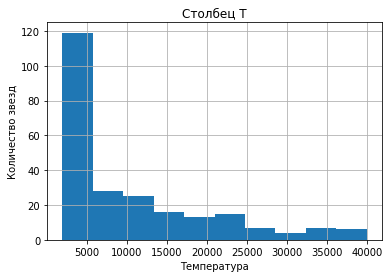

In [15]:
plt.xlabel("Температура")
plt.ylabel("Количество звезд")
plt.title("Столбец T")
df['T'].hist()
plt.show()

Видим что половина звезд имеет температуру, примерно, до 6000К. Кажется, что это может повлиять на работу модели, было бы здорово получить больше данных, что-бы температура распределялась более равномерно.

#### Столбце относительной светимости

Теперь начинаются столбцы фичей.

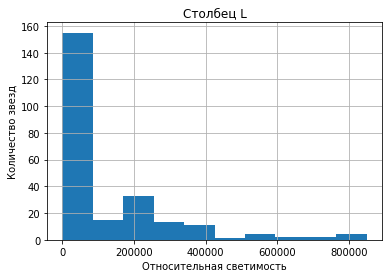

In [16]:
plt.xlabel("Относительная светимость")
plt.ylabel("Количество звезд")
plt.title("Столбец L")
df['L'].hist()
plt.show()

Опять видим похожую картину с темпереатурой, большинстов звезд имеет достаточно низкую относительную светимость.

#### Столбец относительного радиуса 

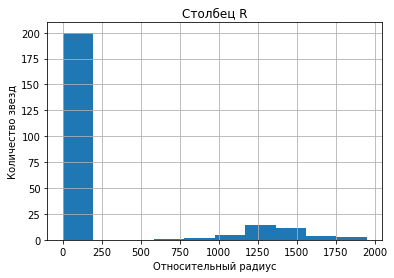

In [17]:
plt.xlabel("Относительный радиус")
plt.ylabel("Количество звезд")
plt.title("Столбец R")
df['R'].hist()
plt.show()

И снова схожая картина, можно сдлеать вывод что нам дали очень много однотипных звезд, думаю столбцы с типом и цветом подскажут как на самом деле.

#### Столбец абсолютной звёздной величины 

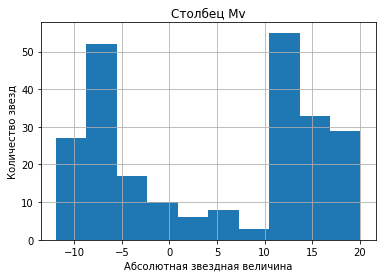

In [18]:
plt.xlabel("Абсолютная звездная величина")
plt.ylabel("Количество звезд")
plt.title("Столбец Mv")
df['Mv'].hist()
plt.show()

Тут распределение уже интереснее.

#### Столбец типа звезды

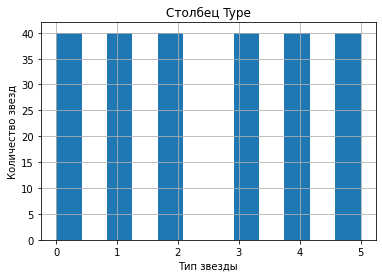

In [68]:
plt.xlabel("Тип звезды")
plt.ylabel("Количество звезд")
plt.title("Столбец Type")
df['Type'].hist(bins = 12)
plt.show()

Значит нам дали по 40 звезд каждого типа, это уже интереснее, получается что звезды разного типа могут совершено разных параметров.

#### Стобце цвета звезды

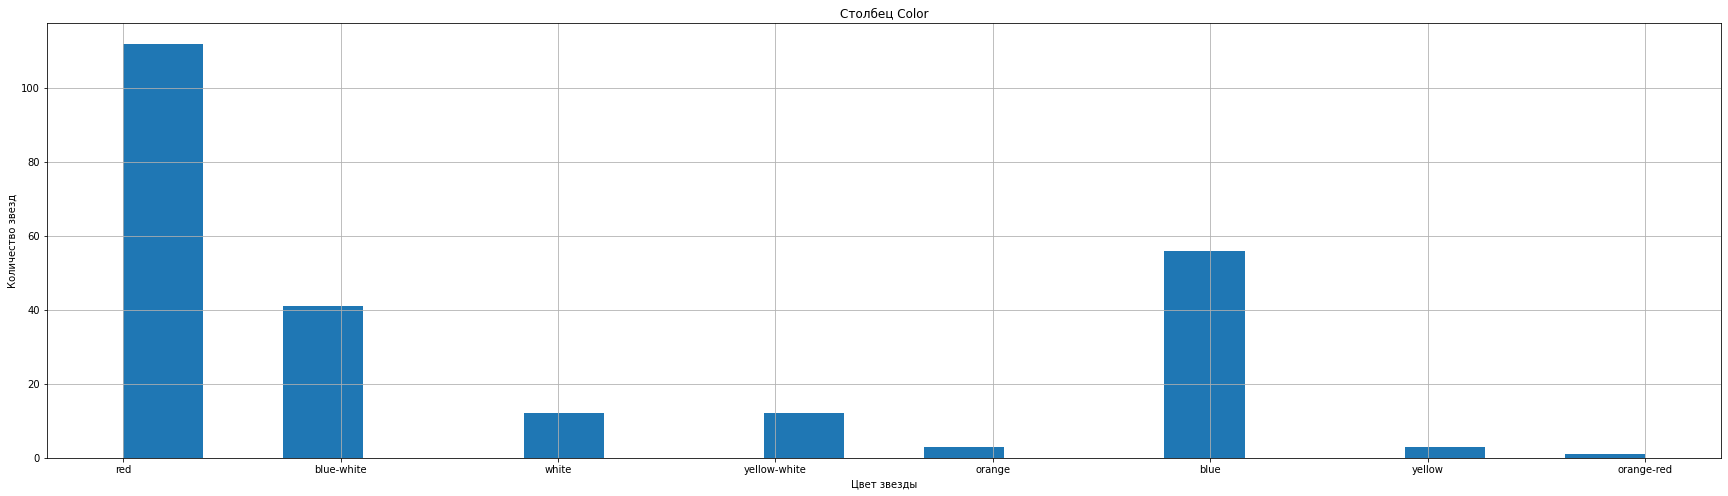

In [70]:
plt.figure(figsize=(30,8))
plt.xlabel("Цвет звезды")
plt.ylabel("Количество звезд")
plt.title("Столбец Color")
df['Color'].hist(bins=19)
plt.show()

Как видно больше ввсего красных звезд, за тем синие, а на третьем месте голубые. Дальше цвета распределяются более-менее равномерно.

Так же из названий цветов виодно, что есть повторения, один и тот-же цвет написаный по разному. Надо это исправить.

In [21]:
display(df['Color'].unique())
len(df['Color'].unique())

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

19

Приведем все к нижниму регистру и уберем пробелы.

In [22]:
df['Color'] = df['Color'].str.lower()
df['Color'] = df['Color'].str.strip()
display(df['Color'].unique())
len(df['Color'].unique())

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'orange', 'white-yellow', 'yellowish',
       'orange-red'], dtype=object)

13

Уже стало лучше, но есть еще пара повторений.

Сделаем следующие замены:
- *blue white* → *blue-white*
- *yellowish white* → *yellow-white*
- *pale yellow orange* → *orange*
- *whitish* → *white*
- *white-yellow* → *yellow-white*
- *yellowish* → *yellow*

In [23]:
df['Color'] = df['Color'].replace({'blue white':'blue-white',
                                   'yellowish white':'yellow-white',
                                   'pale yellow orange':'orange',
                                   'whitish':'white',
                                   'white-yellow':'yellow-white',
                                   'yellowish':'yellow'})

In [24]:
display(df['Color'].unique())
len(df['Color'].unique())

array(['red', 'blue-white', 'white', 'yellow-white', 'orange', 'blue',
       'yellow', 'orange-red'], dtype=object)

8

In [25]:
df['Color'].value_counts()

red             112
blue             56
blue-white       41
white            12
yellow-white     12
orange            3
yellow            3
orange-red        1
Name: Color, dtype: int64

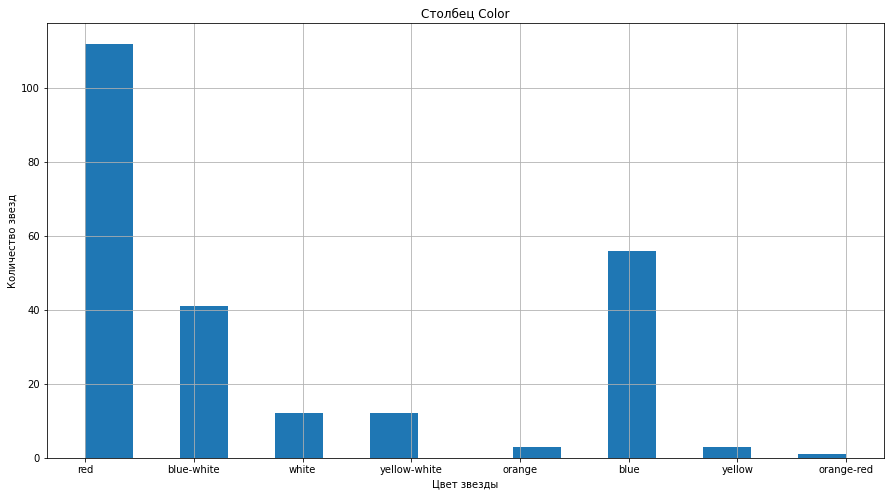

In [26]:
plt.figure(figsize=(15,8))
plt.xlabel("Цвет звезды")
plt.ylabel("Количество звезд")
plt.title("Столбец Color")
df['Color'].hist(bins=16)
plt.show()

Теперь все на много лучше, если отсортировать знгачения по убываю, похоже даже, на часть нормального рспределения.

## Разделение данных на выборки

In [27]:
train, test = train_test_split(df.drop(['Index'], axis =1), test_size=.2, random_state=RANDOM_STATE)
train, vall = train_test_split(train, test_size=.25, random_state=RANDOM_STATE)

In [28]:
get_info(train)

,T,L,R,Mv,Type,Color
187,3484,0.000551,0.0998,16.67,0,red
16,2799,0.001800,0.1600,14.79,1,red
217,19400,10920.000000,6.0300,-3.08,3,blue-white
19,3441,0.039000,0.3510,11.18,1,red
190,3462,0.005300,0.1480,11.47,1,red


<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 70 to 203
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       144 non-null    int64  
 1   L       144 non-null    float64
 2   R       144 non-null    float64
 3   Mv      144 non-null    float64
 4   Type    144 non-null    int64  
 5   Color   144 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 7.9+ KB


None

In [29]:
get_info(vall)

,T,L,R,Mv,Type,Color
61,3432,0.000670,0.1900,16.94,0,red
188,2778,0.000849,0.1120,19.45,0,red
202,14982,0.001180,0.0113,12.23,2,blue
11,3129,0.012200,0.3761,11.79,1,red
133,2989,0.008700,0.3400,13.12,1,red


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 148 to 61
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       48 non-null     int64  
 1   L       48 non-null     float64
 2   R       48 non-null     float64
 3   Mv      48 non-null     float64
 4   Type    48 non-null     int64  
 5   Color   48 non-null     object 
dtypes: float64(3), int64(2), object(1)
memory usage: 2.6+ KB


None

In [30]:
get_info(test)

,T,L,R,Mv,Type,Color
235,38940,374830.00000,1356.000,-9.93,5,blue
196,3142,0.00132,0.258,14.12,1,red
237,8829,537493.00000,1423.000,-10.73,5,white
116,4015,282000.00000,1534.000,-11.39,5,red
150,29560,188000.00000,6.020,-4.01,3,blue-white


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 193 to 211
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       48 non-null     int64  
 1   L       48 non-null     float64
 2   R       48 non-null     float64
 3   Mv      48 non-null     float64
 4   Type    48 non-null     int64  
 5   Color   48 non-null     object 
dtypes: float64(3), int64(2), object(1)
memory usage: 2.6+ KB


None

Отлично, теперь кодирование и масштабирование

In [31]:
cat_columns = ['Type','Color']
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(train[cat_columns])

d:\Python\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [32]:
train_ohe = train.copy()
train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(train[cat_columns])
train_ohe = train_ohe.drop(cat_columns, axis=1)

In [33]:
test_ohe = test.copy()
test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(test[cat_columns])
test_ohe = test_ohe.drop(cat_columns, axis=1)

In [34]:
vall_ohe = vall.copy()
vall_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(vall[cat_columns])
vall_ohe = vall_ohe.drop(cat_columns, axis=1)

In [35]:
get_info(train_ohe)
get_info(test_ohe)
get_info(vall_ohe)

,T,L,R,Mv,Type_1,Type_2,Type_3,Type_4,Type_5,Color_blue-white,Color_orange,Color_orange-red,Color_red,Color_white,Color_yellow,Color_yellow-white
153,16390,1278.00000,5.680,-3.32,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2600,0.00030,0.102,18.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
62,2983,0.00024,0.094,16.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
113,3399,117000.00000,1486.000,-10.92,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,2700,0.00018,0.130,16.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 70 to 203
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   T                   144 non-null    int64  
 1   L                   144 non-null    float64
 2   R                   144 non-null    float64
 3   Mv                  144 non-null    float64
 4   Type_1              144 non-null    float64
 5   Type_2              144 non-null    float64
 6   Type_3              144 non-null    float64
 7   Type_4              144 non-null    float64
 8   Type_5              144 non-null    float64
 9   Color_blue-white    144 non-null    float64
 10  Color_orange        144 non-null    float64
 11  Color_orange-red    144 non-null    float64
 12  Color_red           144 non-null    float64
 13  Color_white         144 non-null    float64
 14  Color_yellow        144 non-null    float64
 15  Color_yellow-white  144 non-null    float64
dtypes: floa

None

,T,L,R,Mv,Type_1,Type_2,Type_3,Type_4,Type_5,Color_blue-white,Color_orange,Color_orange-red,Color_red,Color_white,Color_yellow,Color_yellow-white
10,3600,0.0029,0.51,10.69,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
219,8250,9.2500,1.93,-0.98,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39,5587,0.8190,0.99,5.03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
53,3749,550000.0000,1648.00,-8.05,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
57,3450,174000.0000,1284.00,-11.28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 193 to 211
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   T                   48 non-null     int64  
 1   L                   48 non-null     float64
 2   R                   48 non-null     float64
 3   Mv                  48 non-null     float64
 4   Type_1              48 non-null     float64
 5   Type_2              48 non-null     float64
 6   Type_3              48 non-null     float64
 7   Type_4              48 non-null     float64
 8   Type_5              48 non-null     float64
 9   Color_blue-white    48 non-null     float64
 10  Color_orange        48 non-null     float64
 11  Color_orange-red    48 non-null     float64
 12  Color_red           48 non-null     float64
 13  Color_white         48 non-null     float64
 14  Color_yellow        48 non-null     float64
 15  Color_yellow-white  48 non-null     float64
dtypes: floa

None

,T,L,R,Mv,Type_1,Type_2,Type_3,Type_4,Type_5,Color_blue-white,Color_orange,Color_orange-red,Color_red,Color_white,Color_yellow,Color_yellow-white
139,3541,0.00130,0.2560,14.33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
171,3500,138000.00000,1420.0000,-8.18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
108,24345,142000.00000,57.0000,-6.24,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204,18340,0.00134,0.0124,11.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,3570,320000.00000,1480.0000,-7.58,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 148 to 61
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   T                   48 non-null     int64  
 1   L                   48 non-null     float64
 2   R                   48 non-null     float64
 3   Mv                  48 non-null     float64
 4   Type_1              48 non-null     float64
 5   Type_2              48 non-null     float64
 6   Type_3              48 non-null     float64
 7   Type_4              48 non-null     float64
 8   Type_5              48 non-null     float64
 9   Color_blue-white    48 non-null     float64
 10  Color_orange        48 non-null     float64
 11  Color_orange-red    48 non-null     float64
 12  Color_red           48 non-null     float64
 13  Color_white         48 non-null     float64
 14  Color_yellow        48 non-null     float64
 15  Color_yellow-white  48 non-null     float64
dtypes: float

None

Отбираем фичи и ответы, а дальше масштабируем.

In [36]:
X_train = train_ohe.drop('T', axis=1)
Y_train = train_ohe['T']
X_vall = vall_ohe.drop('T', axis=1)
Y_vall = vall_ohe['T']
X_test = test_ohe.drop('T', axis=1)
Y_test = test_ohe['T']

In [37]:
column = X_train.columns
scaler = StandardScaler()
scaler.fit(X_train[column])
pd.options.mode.chained_assignment = None

In [38]:
X_train[column] = scaler.transform(X_train[column])
X_test[column] = scaler.transform(X_test[column])
X_vall[column] = scaler.transform(X_vall[column])

In [39]:
get_info(X_train)
get_info(X_test)
get_info(X_vall)

,L,R,Mv,Type_1,Type_2,Type_3,Type_4,Type_5,Color_blue-white,Color_orange,Color_orange-red,Color_red,Color_white,Color_yellow,Color_yellow-white
17,-0.58476,-0.466148,0.603611,2.48998,-0.42465,-0.458349,-0.435985,-0.458349,-0.469403,-0.118678,-0.083624,1.042572,-0.208514,-0.083624,-0.208514
178,0.10674,0.887996,-1.127704,-0.40161,-0.42465,-0.458349,-0.435985,2.181742,2.130367,-0.118678,-0.083624,-0.959166,-0.208514,-0.083624,-0.208514
75,-0.58476,-0.466378,0.692778,2.48998,-0.42465,-0.458349,-0.435985,-0.458349,-0.469403,-0.118678,-0.083624,1.042572,-0.208514,-0.083624,-0.208514
129,-0.58476,-0.466883,1.280719,-0.40161,-0.42465,-0.458349,-0.435985,-0.458349,-0.469403,-0.118678,-0.083624,1.042572,-0.208514,-0.083624,-0.208514
100,0.79824,-0.444109,-1.003243,-0.40161,-0.42465,-0.458349,2.293659,-0.458349,-0.469403,-0.118678,-0.083624,-0.959166,-0.208514,-0.083624,-0.208514


<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 70 to 203
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   L                   144 non-null    float64
 1   R                   144 non-null    float64
 2   Mv                  144 non-null    float64
 3   Type_1              144 non-null    float64
 4   Type_2              144 non-null    float64
 5   Type_3              144 non-null    float64
 6   Type_4              144 non-null    float64
 7   Type_5              144 non-null    float64
 8   Color_blue-white    144 non-null    float64
 9   Color_orange        144 non-null    float64
 10  Color_orange-red    144 non-null    float64
 11  Color_red           144 non-null    float64
 12  Color_white         144 non-null    float64
 13  Color_yellow        144 non-null    float64
 14  Color_yellow-white  144 non-null    float64
dtypes: float64(15)
memory usage: 18.0 KB


None

,L,R,Mv,Type_1,Type_2,Type_3,Type_4,Type_5,Color_blue-white,Color_orange,Color_orange-red,Color_red,Color_white,Color_yellow,Color_yellow-white
149,-0.584760,-0.467028,0.643550,-0.40161,2.354879,-0.458349,-0.435985,-0.458349,2.130367,-0.118678,-0.083624,-0.959166,-0.208514,-0.083624,-0.208514
87,-0.584760,-0.467030,0.639835,-0.40161,2.354879,-0.458349,-0.435985,-0.458349,2.130367,-0.118678,-0.083624,-0.959166,-0.208514,-0.083624,-0.208514
196,-0.584760,-0.466554,0.911979,2.48998,-0.424650,-0.458349,-0.435985,-0.458349,-0.469403,-0.118678,-0.083624,1.042572,-0.208514,-0.083624,-0.208514
195,-0.584760,-0.465766,0.869903,2.48998,-0.424650,-0.458349,-0.435985,-0.458349,-0.469403,-0.118678,-0.083624,1.042572,-0.208514,-0.083624,-0.208514
169,1.861536,-0.421171,-0.955873,-0.40161,-0.424650,-0.458349,2.293659,-0.458349,-0.469403,-0.118678,-0.083624,-0.959166,-0.208514,-0.083624,-0.208514


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 193 to 211
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   L                   48 non-null     float64
 1   R                   48 non-null     float64
 2   Mv                  48 non-null     float64
 3   Type_1              48 non-null     float64
 4   Type_2              48 non-null     float64
 5   Type_3              48 non-null     float64
 6   Type_4              48 non-null     float64
 7   Type_5              48 non-null     float64
 8   Color_blue-white    48 non-null     float64
 9   Color_orange        48 non-null     float64
 10  Color_orange-red    48 non-null     float64
 11  Color_red           48 non-null     float64
 12  Color_white         48 non-null     float64
 13  Color_yellow        48 non-null     float64
 14  Color_yellow-white  48 non-null     float64
dtypes: float64(15)
memory usage: 6.0 KB


None

,L,R,Mv,Type_1,Type_2,Type_3,Type_4,Type_5,Color_blue-white,Color_orange,Color_orange-red,Color_red,Color_white,Color_yellow,Color_yellow-white
189,-0.584760,-0.466800,1.119105,-0.40161,-0.42465,-0.458349,-0.435985,-0.458349,-0.469403,-0.118678,-0.083624,1.042572,-0.208514,-0.083624,-0.208514
11,-0.584760,-0.466328,0.695564,2.48998,-0.42465,-0.458349,-0.435985,-0.458349,-0.469403,-0.118678,-0.083624,1.042572,-0.208514,-0.083624,-0.208514
41,1.374489,-0.423083,-0.975378,-0.40161,-0.42465,-0.458349,2.293659,-0.458349,-0.469403,-0.118678,-0.083624,1.042572,-0.208514,-0.083624,-0.208514
133,-0.584760,-0.466397,0.819097,2.48998,-0.42465,-0.458349,-0.435985,-0.458349,-0.469403,-0.118678,-0.083624,1.042572,-0.208514,-0.083624,-0.208514
220,0.822961,-0.400145,-0.981880,-0.40161,-0.42465,-0.458349,2.293659,-0.458349,-0.469403,-0.118678,-0.083624,-0.959166,-0.208514,-0.083624,-0.208514


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 148 to 61
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   L                   48 non-null     float64
 1   R                   48 non-null     float64
 2   Mv                  48 non-null     float64
 3   Type_1              48 non-null     float64
 4   Type_2              48 non-null     float64
 5   Type_3              48 non-null     float64
 6   Type_4              48 non-null     float64
 7   Type_5              48 non-null     float64
 8   Color_blue-white    48 non-null     float64
 9   Color_orange        48 non-null     float64
 10  Color_orange-red    48 non-null     float64
 11  Color_red           48 non-null     float64
 12  Color_white         48 non-null     float64
 13  Color_yellow        48 non-null     float64
 14  Color_yellow-white  48 non-null     float64
dtypes: float64(15)
memory usage: 6.0 KB


None

In [40]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
X_vall = torch.FloatTensor(X_vall.values)
Y_train = torch.FloatTensor(Y_train.values)
Y_test = torch.FloatTensor(Y_test.values)
Y_vall = torch.FloatTensor(Y_vall.values)

Теперь все есть для обучения модели, осталось создать нейроную сеть.

## Построение базовой нейронной сети

Построим пару случайных сетей и посмотрим как они работают

In [41]:
n_neurons = [15, 12, 8, 15, 6, 1]
net_layers1 = []

for i in range(1, len(n_neurons) - 1):
		net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
		if (i+1) % 2 == 0:
				net_layers1.append(nn.Tanh()) 
net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
net1 = nn.Sequential(*net_layers1)

In [42]:
L1_train = []
L1_test = []

In [43]:
optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)

loss = nn.MSELoss()

num_epochs = 15000
for epoch in range(num_epochs):
    net1.train()
    optimizer.zero_grad()
    
    preds = net1.forward(X_train).flatten()
    loss_value = torch.sqrt(loss(preds, Y_train))
    loss_value.backward()
    
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == num_epochs-1:
        L1_train.append(loss_value.detach().numpy())
        net1.eval()
        test_pred = net1.forward(X_vall).flatten()
        L1 = torch.sqrt(loss(test_pred,Y_vall))
        L1_test.append(L1.detach().numpy())

In [44]:
n_neurons = [15, 12, 8, 20, 5, 1]
net_layers = []

for i in range(1, len(n_neurons) - 1):
		net_layers.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
		if (i+1) % 2 == 0:
			net_layers.append(nn.BatchNorm1d(n_neurons[i]))
			net_layers.append(nn.Tanh()) 
		else:
			net_layers.append(nn.BatchNorm1d(n_neurons[i]))

net_layers.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
net_bn = nn.Sequential(*net_layers)

In [45]:
L1_train_bn= []
L1_test_bn = []

In [46]:
optimizer = torch.optim.Adam(net_bn.parameters(),lr=1e-3)

loss = nn.MSELoss()

l1_lambda = 0.001
num_epochs = 15000
for epoch in range(num_epochs):
    net_bn.train()
    optimizer.zero_grad()
    
    preds = net_bn.forward(X_train).flatten()
    loss_value = torch.sqrt(loss(preds, Y_train))
    loss_value.backward()
    
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == num_epochs-1:
        L1_train_bn.append(loss_value.detach().numpy())
        net_bn.eval()
        test_pred = net_bn.forward(X_vall).flatten()
        L1 = torch.sqrt(loss(test_pred,Y_vall))
        L1_test_bn.append(L1.detach().numpy())

In [47]:
n_neurons = [15, 12, 8, 20, 5, 1]
net_layers = []

for i in range(1, len(n_neurons) - 1):
		net_layers.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
		if (i+1) % 2 == 0:
			net_layers.append(nn.Dropout(p=0.2))
			net_layers.append(nn.Tanh()) 
		else:
			net_layers.append(nn.Dropout(p=.3))

net_layers.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
net_d = nn.Sequential(*net_layers)

In [48]:
L1_train_d= []
L1_test_d = []

In [49]:
optimizer = torch.optim.Adam(net_d.parameters(),lr=1e-3)

loss = nn.MSELoss()

l1_lambda = 0.001
num_epochs = 15000
for epoch in range(num_epochs):
    net_d.train()
    optimizer.zero_grad()
    
    preds = net_d.forward(X_train).flatten()
    loss_value = torch.sqrt(loss(preds, Y_train))
    loss_value.backward()
    
    optimizer.step()
    
    if epoch % 100 == 0 or epoch == num_epochs-1:
        L1_train_d.append(loss_value.detach().numpy())
        net_d.eval()
        test_pred = net_d.forward(X_vall).flatten()
        L1 = torch.sqrt(loss(test_pred,Y_vall))
        L1_test_d.append(L1.detach().numpy())

In [50]:
n_neurons = [15, 24, 32, 28, 25, 1]
net_layers_bc = []

for i in range(1, len(n_neurons) - 1):
		net_layers_bc.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
		if (i+1) % 2 == 0:
				net_layers_bc.append(nn.Tanh()) 
net_layers_bc.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
net_bc = nn.Sequential(*net_layers_bc)

In [51]:
L1_train_bc = []
L1_test_bc = []

In [52]:
optimizer = torch.optim.Adam(net_bc.parameters(), lr=1e-3)

loss = nn.MSELoss()

batch_size = 40

num_epochs = 15000

num_batches = ceil(len(X_train)/batch_size)

for epoch in range(num_epochs):
	net_bn.train()
	order = np.random.permutation(len(X_train))
	lo = []
	for batch_idx in range(num_batches):
		start_index = batch_idx * batch_size
		optimizer.zero_grad()
  
		batch_indexes = order[start_index:start_index+batch_size]
		X_batch = X_train[batch_indexes]
		y_batch = Y_train[batch_indexes]
  
		preds = net_bc.forward(X_batch).flatten()
		loss_value = torch.sqrt(loss(preds, y_batch))
		lo.append(loss_value.detach().numpy())
		loss_value.backward()
	        
		optimizer.step()
		
	if epoch % 100 == 0 or epoch == num_epochs - 1:
		L1_train_bc.append(np.mean(lo))
		net_bc.eval()
		test_preds = net_bc.forward(X_vall).flatten()
		L1 = torch.sqrt(loss(test_preds,Y_vall))
		L1_test_bc.append(L1.detach().numpy())


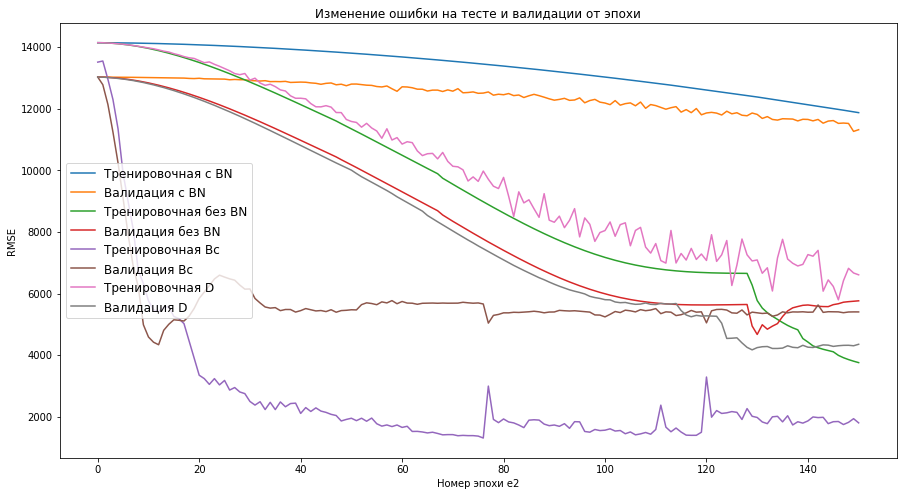

In [53]:
x = np.array(range(0, len(L1_test_bn)))
plt.figure(figsize=(15,8))
plt.title('Изменение ошибки на тесте и валидации от эпохи')
plt.xlabel('Номер эпохи е2')
plt.ylabel('RMSE')
plt.plot(x,L1_train_bn,label='Тренировочная с BN')
plt.plot(x,L1_test_bn,label='Валидация с BN')
plt.plot(x,L1_train,label='Тренировочная без BN')
plt.plot(x,L1_test,label='Валидация без BN')
plt.plot(x,L1_train_bc,label='Тренировочная Bc')
plt.plot(x,L1_test_bc,label='Валидация Bc')
plt.plot(x,L1_train_d,label='Тренировочная D')
plt.plot(x,L1_test_d,label='Валидация D')
plt.legend(loc='best', fontsize=12)
plt.show()

In [54]:
display(f'{mean_squared_error(Y_test.detach(), net_bc.forward(X_test).flatten().detach(), squared=False)} bc')
display(f'{mean_squared_error(Y_test.detach(), net_bn.forward(X_test).flatten().detach(), squared=False)} bn')
display(f'{mean_squared_error(Y_test.detach(), net1.forward(X_test).flatten().detach(), squared=False)}')
display(f'{mean_squared_error(Y_test.detach(), net_d.forward(X_test).flatten().detach(), squared=False)} D')

'5164.80419921875 bc'

'13584.6484375 bn'

'5914.68408203125'

'6511.0625 D'

Как можно заметить все модели плюс минус одинаковые получились, за исключениме модели с BatchNorm1d. Теперь нужно понять какие параметры самые лучшие для данной задачи.

## Улучшение нейронной сети

Что бы понять какие параметры самые лучшие, обучим 500 случайносгенерированых сетей, с разным количество слоем (от 0 до 8) и количество нейронов от 2 до 100 и посмотрим какие парметры самые лучшие.

In [55]:
conf = []
for g in range(500):
    l = np.random.randint(0,8)
    n_neurons = [15]
    net_layers1 = []
    for j in range(l):
        n_neurons.append(np.random.randint(2,100))
    n_neurons.append(1)

    for i in range(1, len(n_neurons) - 1):
            net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
            if (i+1) % 2 == 0:
                    net_layers1.append(nn.Tanh()) 
    net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
    net1 = nn.Sequential(*net_layers1)
    L1_train = []
    L1_test = []
    optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)
    conf.append([g,n_neurons])
    loss = nn.MSELoss()

    num_epochs = 20000
    for epoch in range(num_epochs):
        net1.train()
        optimizer.zero_grad()
        
        preds = net1.forward(X_train).flatten()
        loss_value = torch.sqrt(loss(preds, Y_train))
        loss_value.backward()
        
        optimizer.step()
        
        if epoch % 100 == 0 or epoch == num_epochs-1:
            L1_train.append(loss_value.detach().numpy())
            net1.eval()
            test_pred = net1.forward(X_vall).flatten()
            L1 = torch.sqrt(loss(test_pred,Y_vall))
            L1_test.append(L1.detach().numpy())
    rmse = mean_squared_error(Y_test.detach(), net1.forward(X_test).flatten().detach(), squared=False)
    conf[g].append(rmse)
    x = np.array(range(0, len(L1_train)))
    if (g + 1) % 10 == 1:
         plt.figure(figsize=(20,12))
    plt.plot(x,L1_train,label=f'Train {g}')
    plt.plot(x,L1_test,label=f'Test {g}')
    plt.legend(loc='best', fontsize=12)
    if (g + 1) % 10 == 0:
         plt.show()
plt.figure(figsize=(20,12))
for i in range(len(conf)):
     plt.scatter(i,conf[i][2])
     plt.annotate(f"{i}", xy=[i,conf[i][2]+1])

Для удобства переведем результат в DF. 

In [56]:
k = pd.DataFrame(conf)

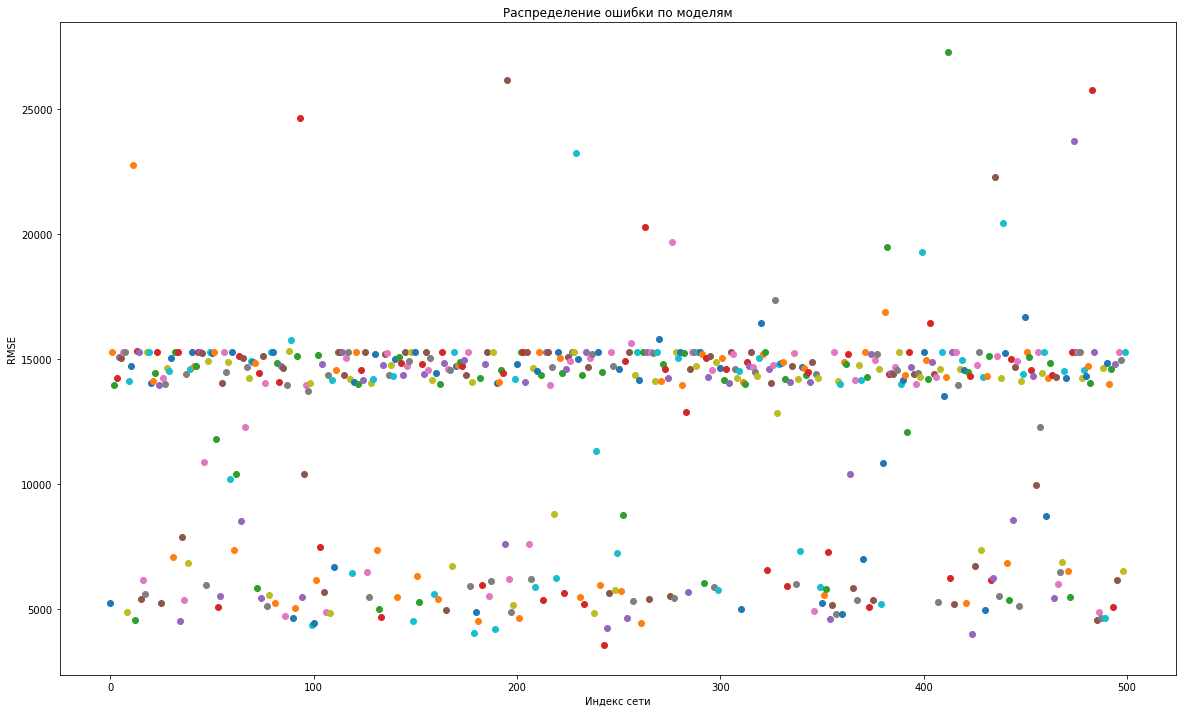

In [57]:
plt.figure(figsize=(20,12))
plt.title('Распределение ошибки по моделям')
plt.xlabel('Индекс сети')
plt.ylabel('RMSE')
for i in range(len(conf)):
    plt.scatter(i,conf[i][2])
plt.show()

Как видно большенство моделей показывабт результат в районе 15к, что очень много. Оставим модели которые смогли опуститься ниже 5000.

In [58]:
k = k.loc[k[2] < 5000]

In [59]:
k

,0,1,2
8,8,"[15, 45, 87, 68, 73, 41, 79, 1]",4874.550781
12,12,"[15, 33, 7, 1]",4538.178223
34,34,"[15, 45, 33, 38, 86, 1]",4515.955078
86,86,"[15, 13, 79, 70, 92, 37, 43, 1]",4732.080566
90,90,"[15, 44, 96, 63, 64, 1]",4642.940918
99,99,"[15, 6, 31, 1]",4372.120117
100,100,"[15, 62, 31, 70, 45, 33, 65, 1]",4431.179199
106,106,"[15, 59, 77, 9, 66, 80, 63, 1]",4878.415527
108,108,"[15, 39, 32, 4, 6, 58, 57, 1]",4843.550781
133,133,"[15, 34, 9, 1]",4667.038086


Их достаточно что бы понять какое средне значение слоев необходимо

4.666666666666667


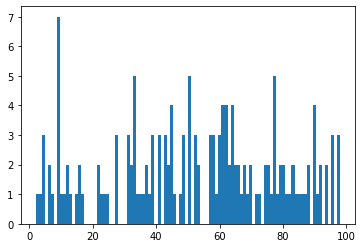

In [60]:
s = 0
n =[]
for j in k[1]:
    s += len(j) - 2
    for i in j[1:-1]:
        n.append(i)
print(s/len(k[1]))
plt.hist(n,bins=100)
plt.show()

количество нейронов распеределено +- равномерно, и тут сложно сделать выводыб возьмем от 20 до 30, скорее всего маленькая выборка. А вот количество слоев 4, попробуем поиграться с этим.

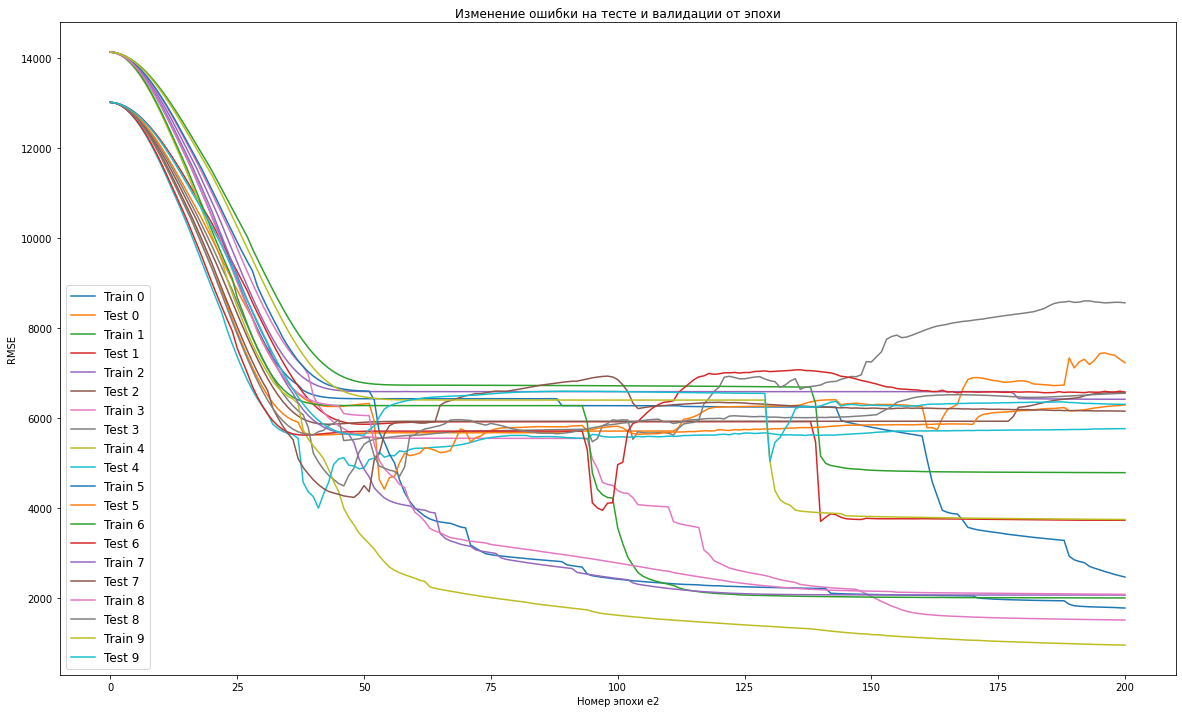

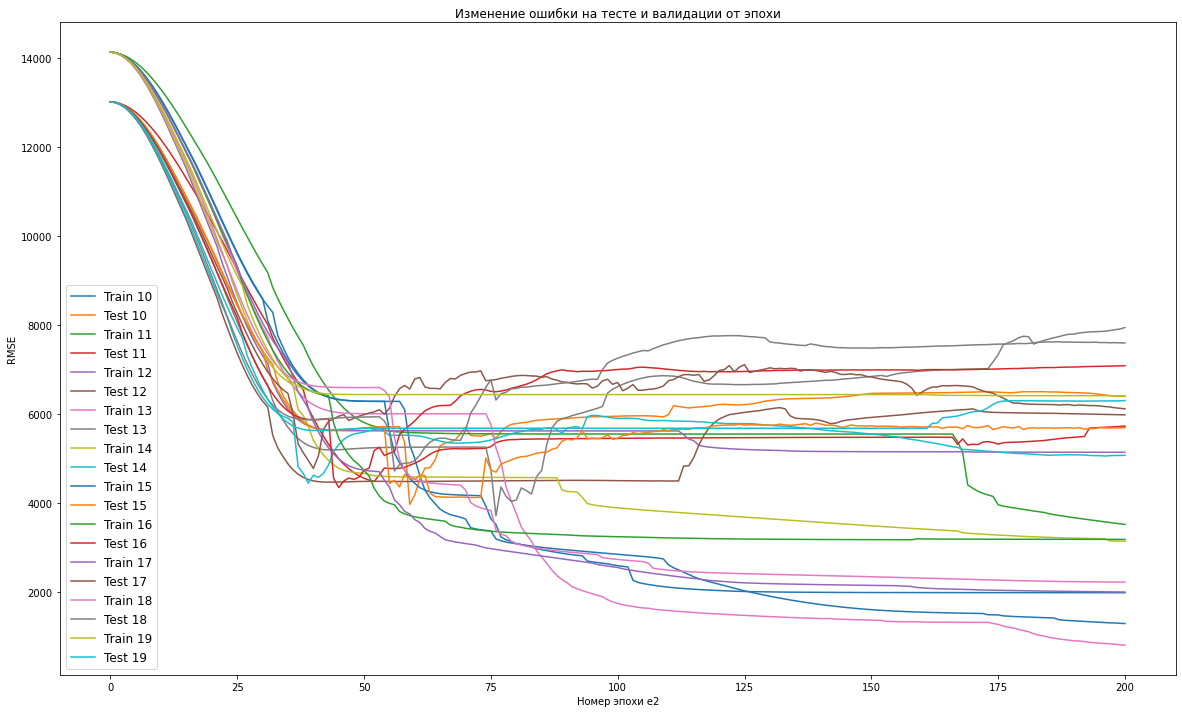

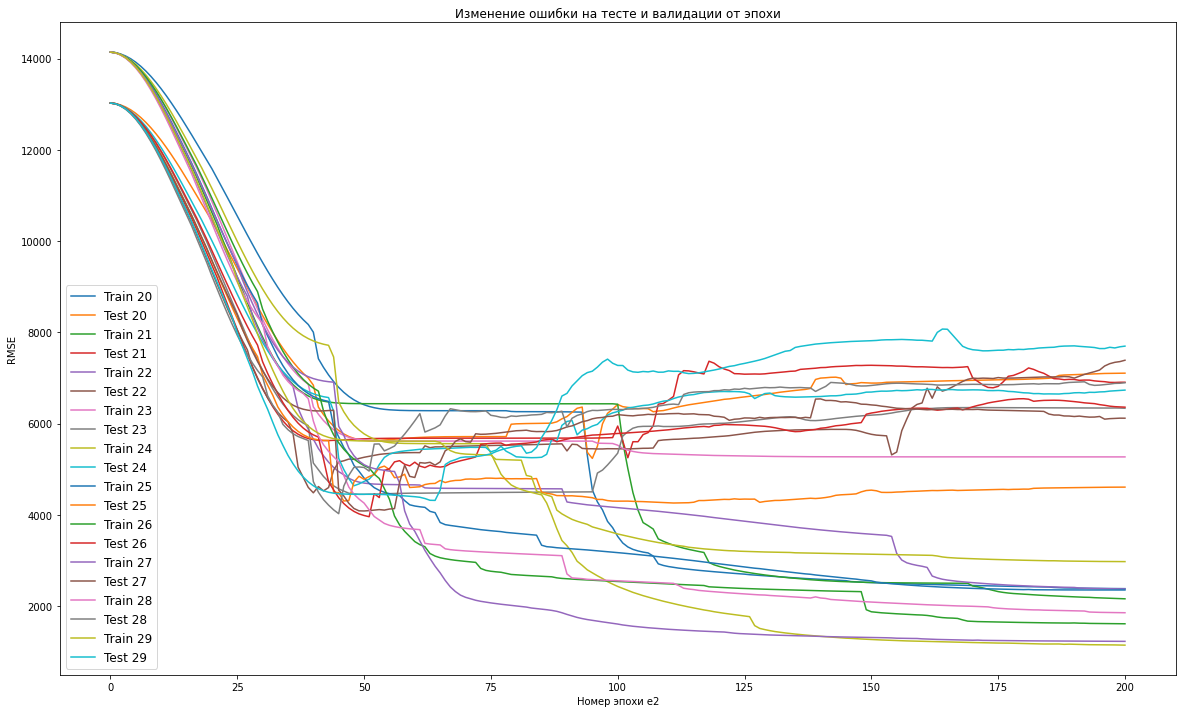

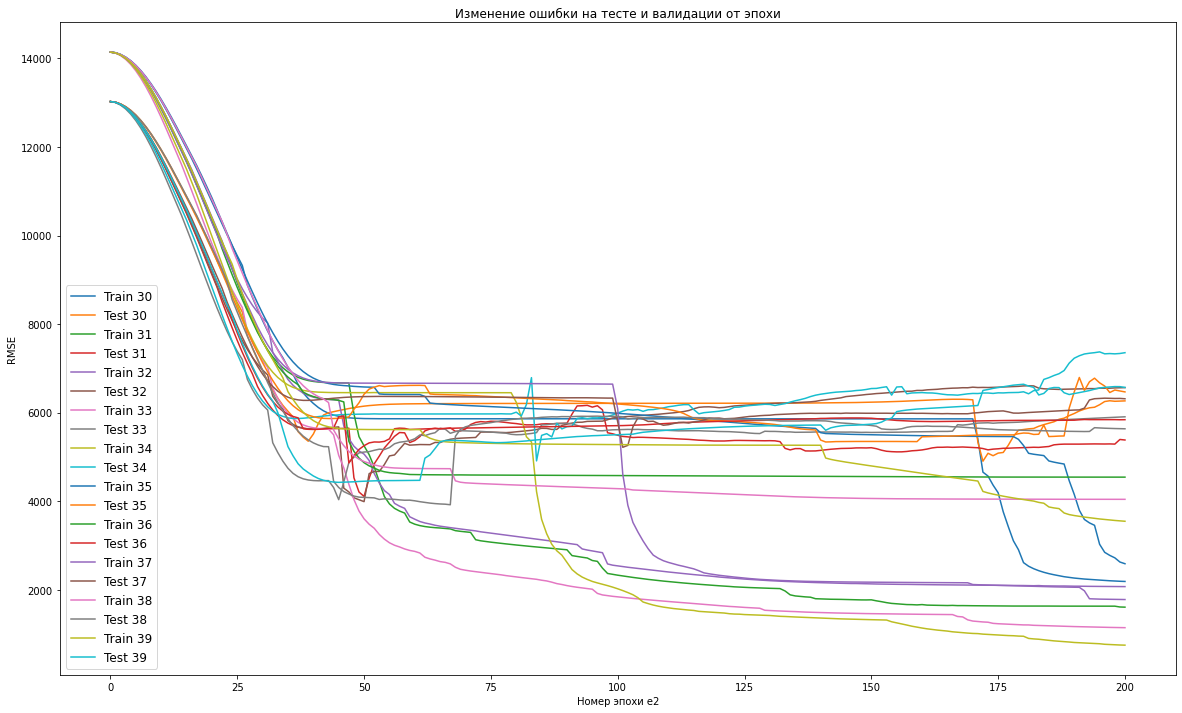

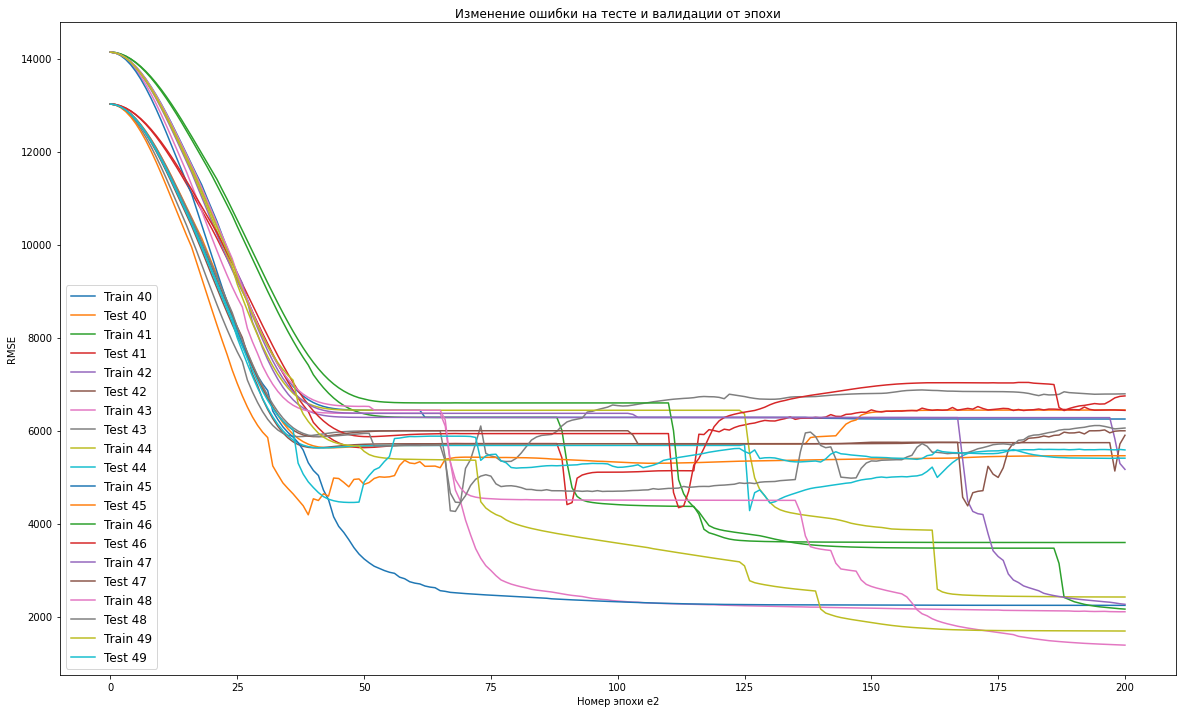

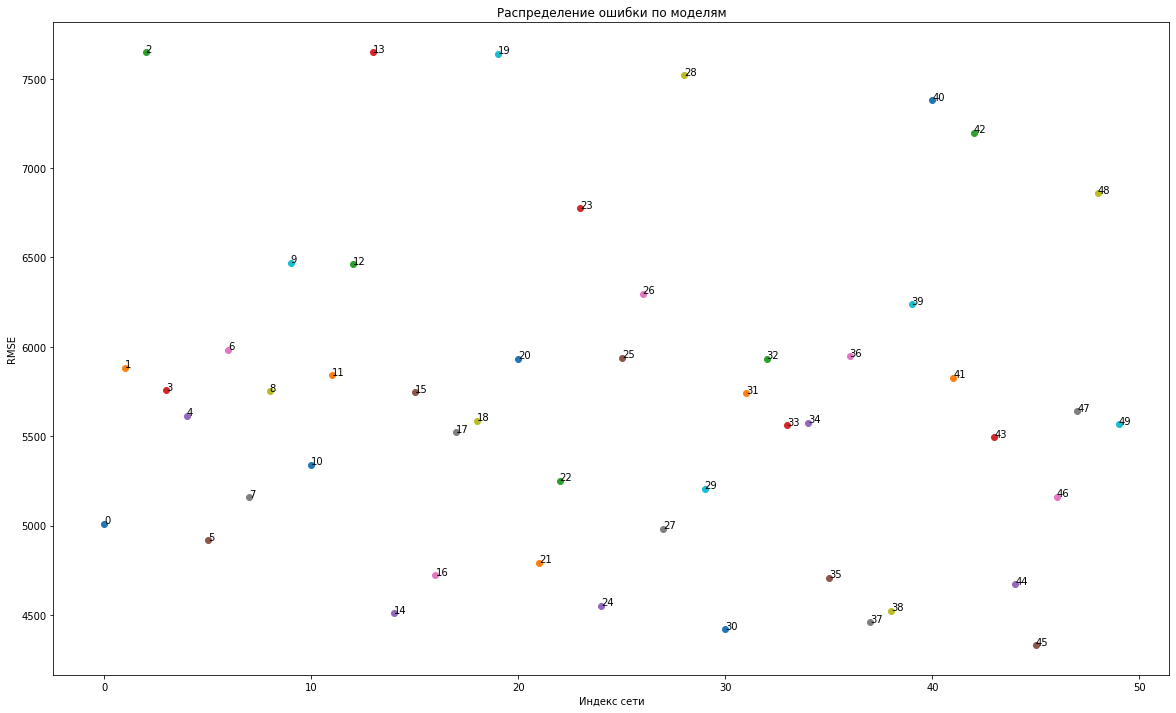

In [61]:
conf = []
for g in range(50):
    l = 4
    n_neurons = [15]
    net_layers1 = []
    for j in range(l):
        n_neurons.append(np.random.randint(20,30))
    n_neurons.append(1)

    for i in range(1, len(n_neurons) - 1):
            net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
            if (i+1) % 2 == 0:
                    net_layers1.append(nn.Tanh()) 
    net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
    net1 = nn.Sequential(*net_layers1)
    L1_train = []
    L1_test = []
    optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)
    conf.append([g,n_neurons])
    loss = nn.MSELoss()

    num_epochs = 20000
    for epoch in range(num_epochs):
        net1.train()
        optimizer.zero_grad()
        
        preds = net1.forward(X_train).flatten()
        loss_value = torch.sqrt(loss(preds, Y_train))
        loss_value.backward()
        
        optimizer.step()
        
        if epoch % 100 == 0 or epoch == num_epochs-1:
            L1_train.append(loss_value.detach().numpy())
            net1.eval()
            test_pred = net1.forward(X_vall).flatten()
            L1 = torch.sqrt(loss(test_pred,Y_vall))
            L1_test.append(L1.detach().numpy())
    rmse = mean_squared_error(Y_test.detach(), net1.forward(X_test).flatten().detach(), squared=False)
    conf[g].append(rmse)
    conf[g].append(net1)
    x = np.array(range(0, len(L1_train)))
    if (g + 1) % 10 == 1:
        plt.figure(figsize=(20,12))
        plt.title('Изменение ошибки на тесте и валидации от эпохи')
        plt.xlabel('Номер эпохи е2')
        plt.ylabel('RMSE')
    plt.plot(x,L1_train,label=f'Train {g}')
    plt.plot(x,L1_test,label=f'Test {g}')
    plt.legend(loc='best', fontsize=12)
    if (g + 1) % 10 == 0:
         plt.show()
plt.figure(figsize=(20,12))
plt.title('Распределение ошибки по моделям')
plt.xlabel('Индекс сети')
plt.ylabel('RMSE')
for i in range(len(conf)):
     plt.scatter(i,conf[i][2])
     plt.annotate(f"{i}", xy=[i,conf[i][2]+1])
plt.show()

Видим тут не плохие модели, запомним их номер, применим для финального крафика.

Как видно из графиков все сети показывают не плохие результаты, значит для нас это подходящие параметры. Теперь необходимо остановить обучение когда результат валидации начинает рости.

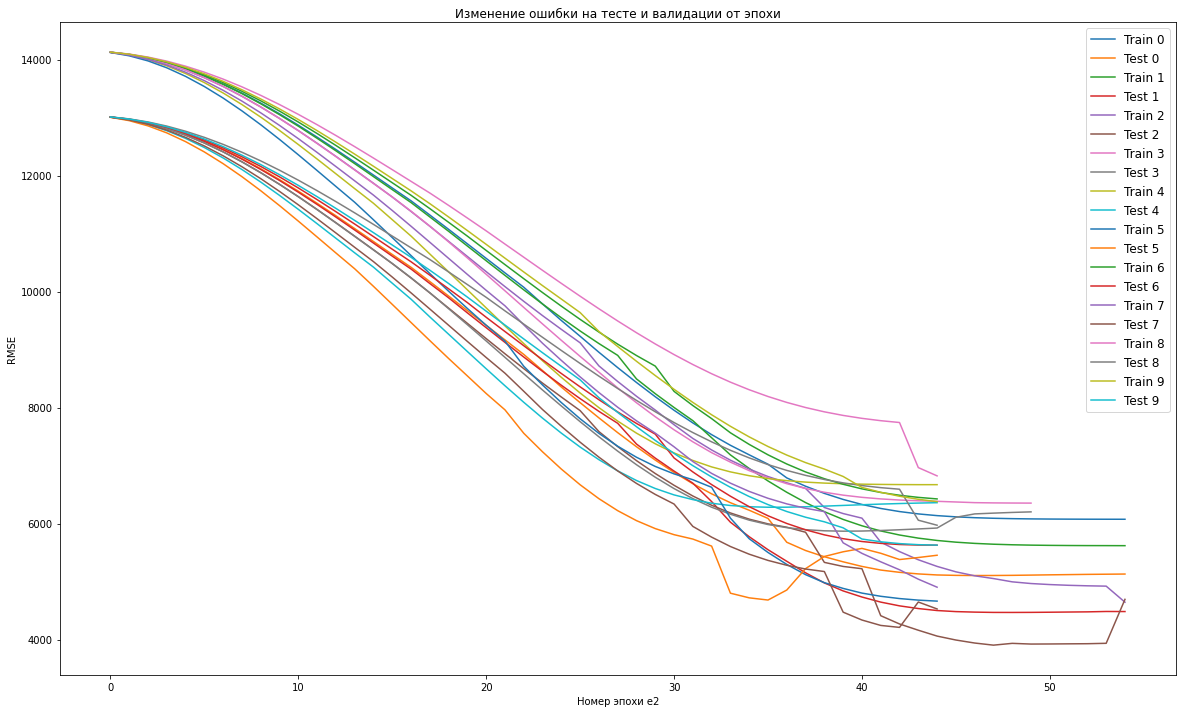

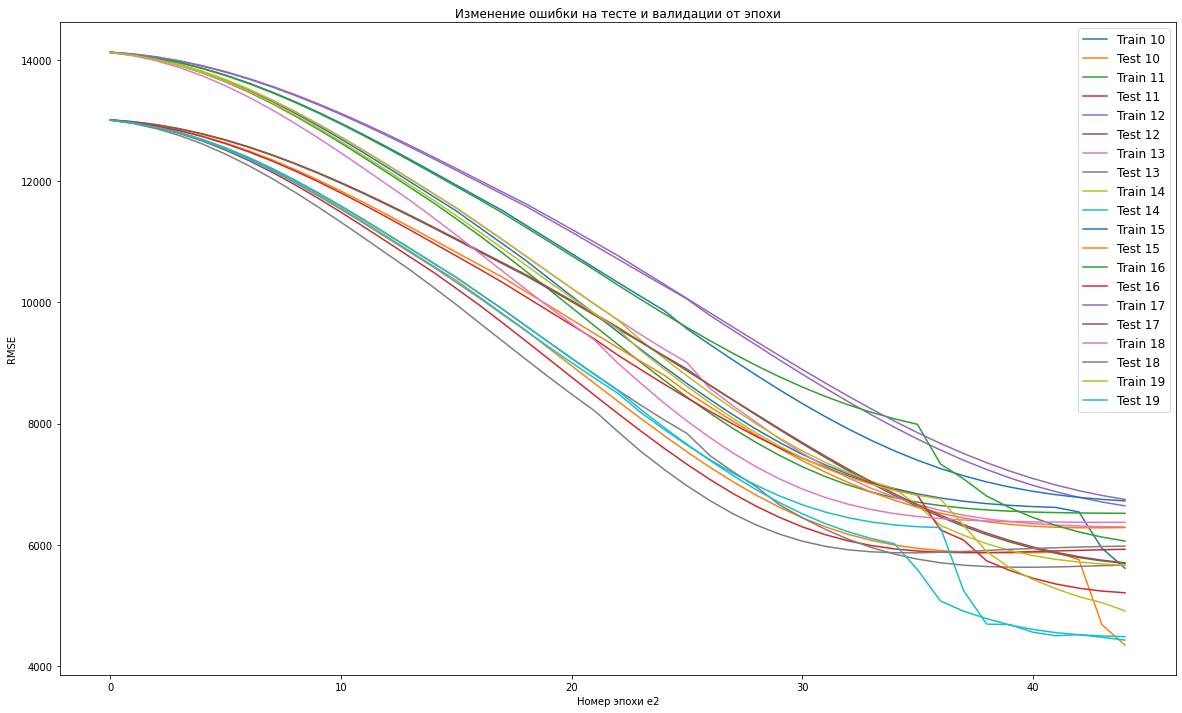

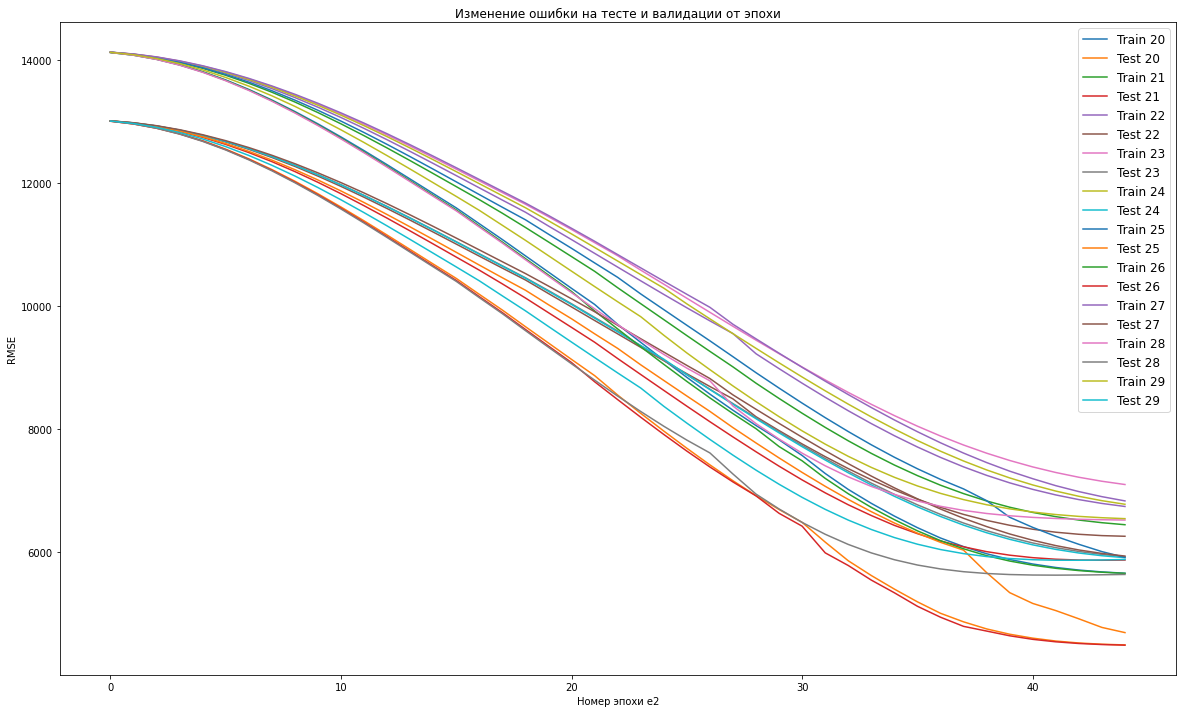

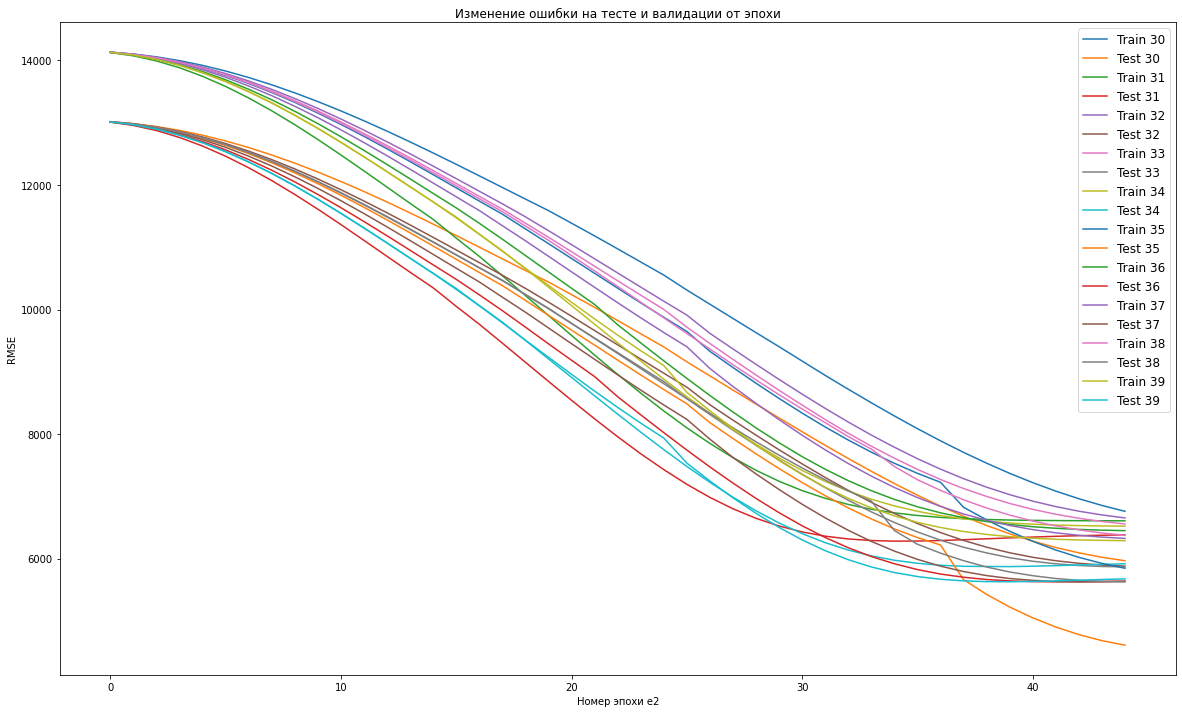

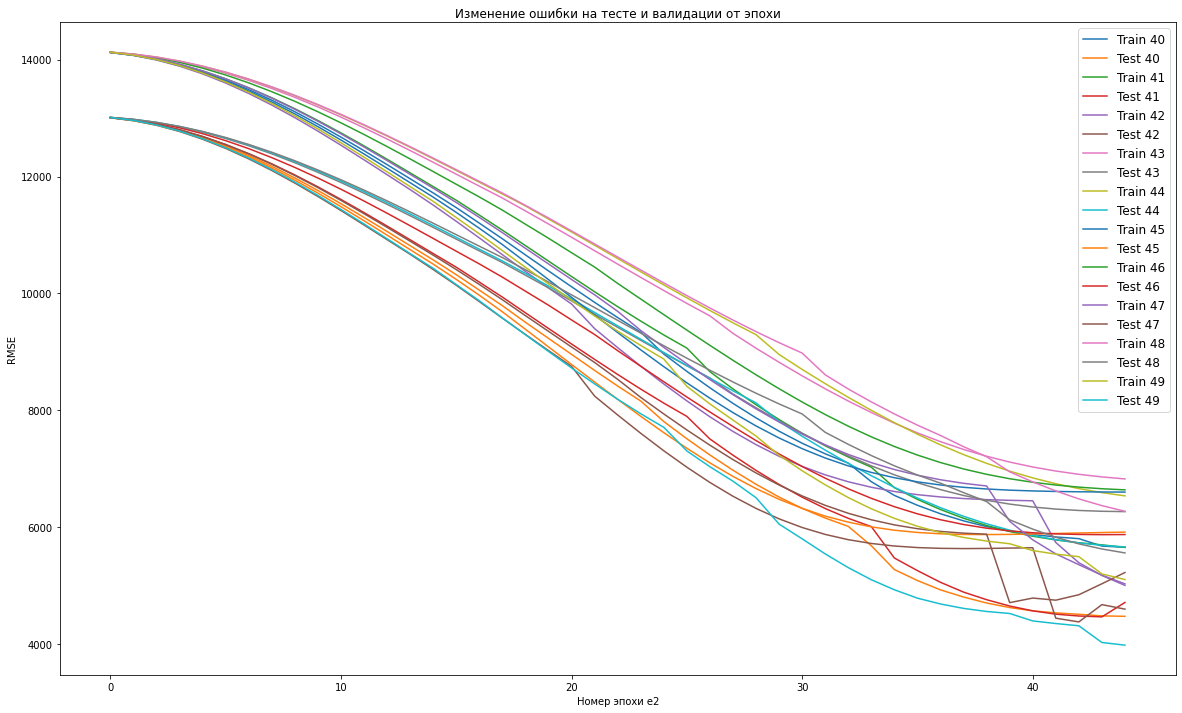

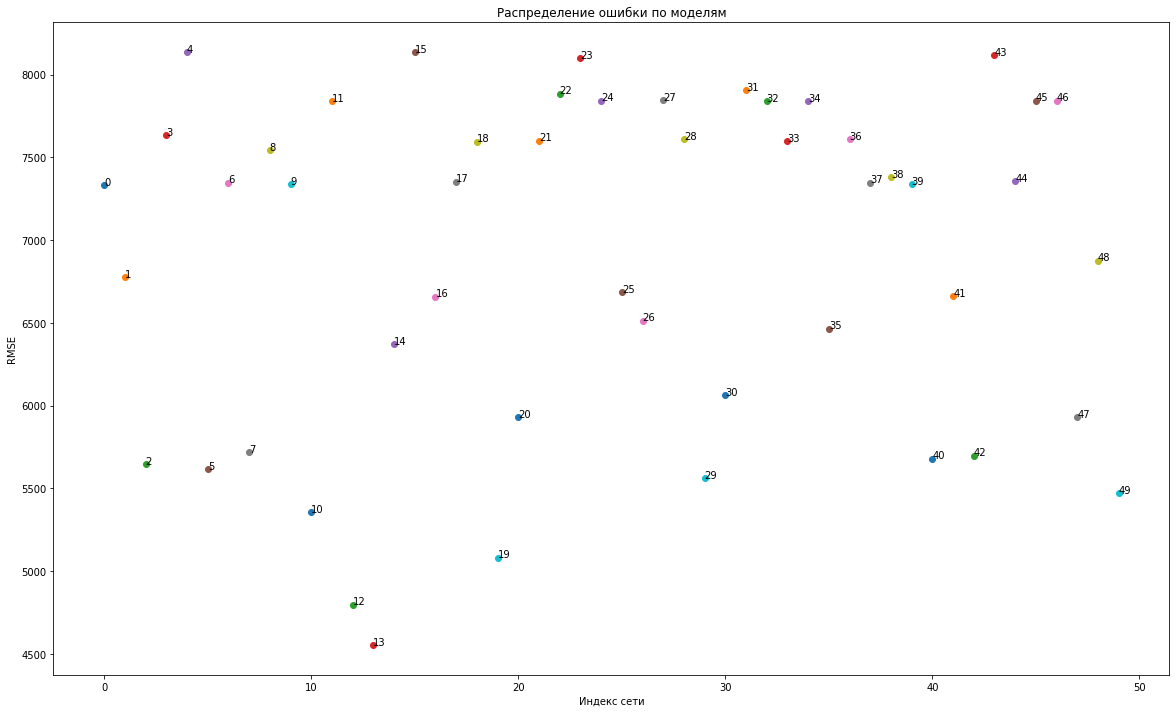

In [62]:
conf = []
x = np.array(range(0,200))
for g in range(50):
    p = 0
    d = 5
    mean = [20000]
    l = 4
    n_neurons = [15]
    net_layers1 = []
    for j in range(l):
        n_neurons.append(np.random.randint(20,30))
    n_neurons.append(1)

    for i in range(1, len(n_neurons) - 1):
            net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
            if (i+1) % 2 == 0:
                net_layers1.append(nn.Tanh()) 
    net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
    net1 = nn.Sequential(*net_layers1)
    L1_train = []
    L1_test = []
    optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)
    conf.append([g,n_neurons])
    loss = nn.MSELoss()

    num_epochs = 20000
    for epoch in range(num_epochs):
        net1.train()
        optimizer.zero_grad()
        
        preds = net1.forward(X_train).flatten()
        loss_value = torch.sqrt(loss(preds, Y_train))
        loss_value.backward()
        
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            L1_train.append(loss_value.detach().numpy())
            net1.eval()
            test_pred = net1.forward(X_vall).flatten()
            L1 = torch.sqrt(loss(test_pred,Y_vall))
            L1_test.append(L1.detach().numpy())
            if (epoch + 1) % (d*100) == 0:
                mean.append(sum(L1_test[p:p+d])/d)
                p += d
                if mean[-1] > mean[-2]: break
                
    rmse = mean_squared_error(Y_test.detach(), net1.forward(X_test).flatten().detach(), squared=False)
    conf[g].append(rmse)
    conf[g].append(net1)
    if len(x) > len(L1_train): x = np.array(range(0, len(L1_train)))
    if (g + 1) % 10 == 1:
        plt.figure(figsize=(20,12))
        plt.title('Изменение ошибки на тесте и валидации от эпохи')
        plt.xlabel('Номер эпохи е2')
        plt.ylabel('RMSE')
    plt.plot(x,L1_train[0:len(x)],label=f'Train {g}')
    plt.plot(x,L1_test[0:len(x)],label=f'Test {g}')
    plt.legend(loc='best', fontsize=12)
    if (g + 1) % 10 == 0:
        plt.show()
plt.figure(figsize=(20,12))
plt.title('Распределение ошибки по моделям')
plt.xlabel('Индекс сети')
plt.ylabel('RMSE')
for i in range(len(conf)):
     plt.scatter(i,conf[i][2])
     plt.annotate(f"{i}", xy=[i,conf[i][2]+1])
plt.show()

Как видно, модели не переобучаются а останавливаются в своем минимуме, теперь нужно к ним добавить батчи и посмотреть на результаты.

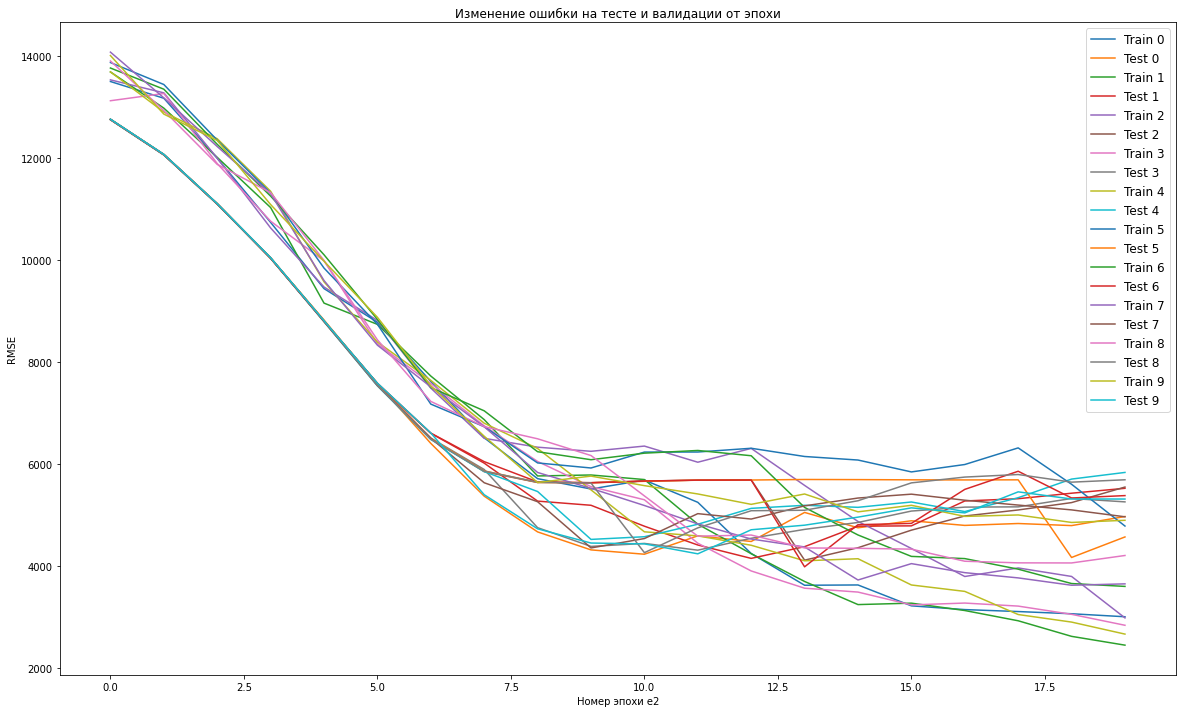

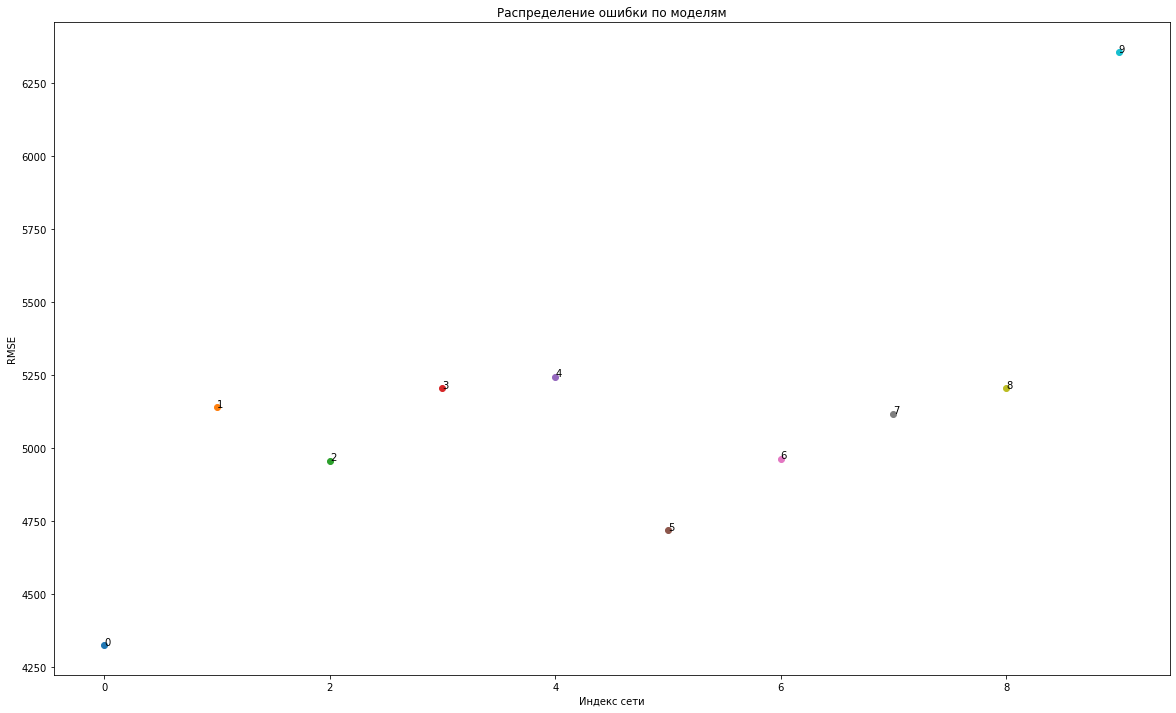

In [63]:
conf_bc = []
x = np.array(range(0,200))
for g in range(10):
    p = 0
    d = 5
    mean = [20000]
    l = 4
    n_neurons = [15]
    net_layers1 = []
    for j in [28, 21, 35, 22]:
        n_neurons.append(j)
    n_neurons.append(1)

    for i in range(1, len(n_neurons) - 1):
        net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
        if (i+1) % 2 == 0:
                net_layers1.append(nn.Tanh()) 
    net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
    net1 = nn.Sequential(*net_layers1)
    L1_train = []   
    L1_test = []
    optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)
    conf_bc.append([g,n_neurons])

    loss = nn.MSELoss()
    batch_size = 40

    num_epochs = 15000

    num_batches = ceil(len(X_train)/batch_size)
    num_epochs = 20000
    for epoch in range(num_epochs):
        net1.train()
        order = np.random.permutation(len(X_train))
        lo = []
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()
    
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = Y_train[batch_indexes]
    
            preds = net1.forward(X_batch).flatten()
            loss_value = torch.sqrt(loss(preds, y_batch))
            lo.append(loss_value.detach().numpy())
            loss_value.backward()
                
            optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            L1_train.append(np.mean(lo))
            net1.eval()
            test_pred = net1.forward(X_vall).flatten()
            L1 = torch.sqrt(loss(test_pred,Y_vall))
            L1_test.append(L1.detach().numpy())
            if (epoch + 1) % (d*100) == 0:
                mean.append(sum(L1_test[p:p+d])/d)
                p += d
                if mean[-1] > mean[-2]: break
                
    rmse = mean_squared_error(Y_test.detach(), net1.forward(X_test).flatten().detach(), squared=False)
    conf_bc[g].append(rmse)
    conf_bc[g].append(net1)
    if len(x) > len(L1_train): x = np.array(range(0, len(L1_train)))
    if (g + 1) % 10 == 1:
        plt.figure(figsize=(20,12))
        plt.title('Изменение ошибки на тесте и валидации от эпохи')
        plt.xlabel('Номер эпохи е2')
        plt.ylabel('RMSE')        
    plt.plot(x,L1_train[0:len(x)],label=f'Train {g}')
    plt.plot(x,L1_test[0:len(x)],label=f'Test {g}')
    plt.legend(loc='best', fontsize=12)
    if (g + 1) % 10 == 0:
        plt.show()
plt.figure(figsize=(20,12))
plt.title('Распределение ошибки по моделям')
plt.xlabel('Индекс сети')
plt.ylabel('RMSE')
for i in range(len(conf_bc)):
    plt.scatter(i,conf_bc[i][2])
    plt.annotate(f"{i}", xy=[i,conf_bc[i][2]+1])
plt.show()

In [64]:
from operator import itemgetter
net = sorted(conf_bc, key=itemgetter(2))[0][3]
net_t = sorted(conf, key=itemgetter(2))[0][3]

In [65]:
display(f'{mean_squared_error(Y_test.detach(), net_t.forward(X_test).flatten().detach(), squared=False)} без бачей')
display(f'{mean_squared_error(Y_test.detach(), net.forward(X_test).flatten().detach(), squared=False)} с бачами')

'4552.2705078125 без бачей'

'4324.04833984375 с бачами'

Не плохой результат, осталось нарисовать график.

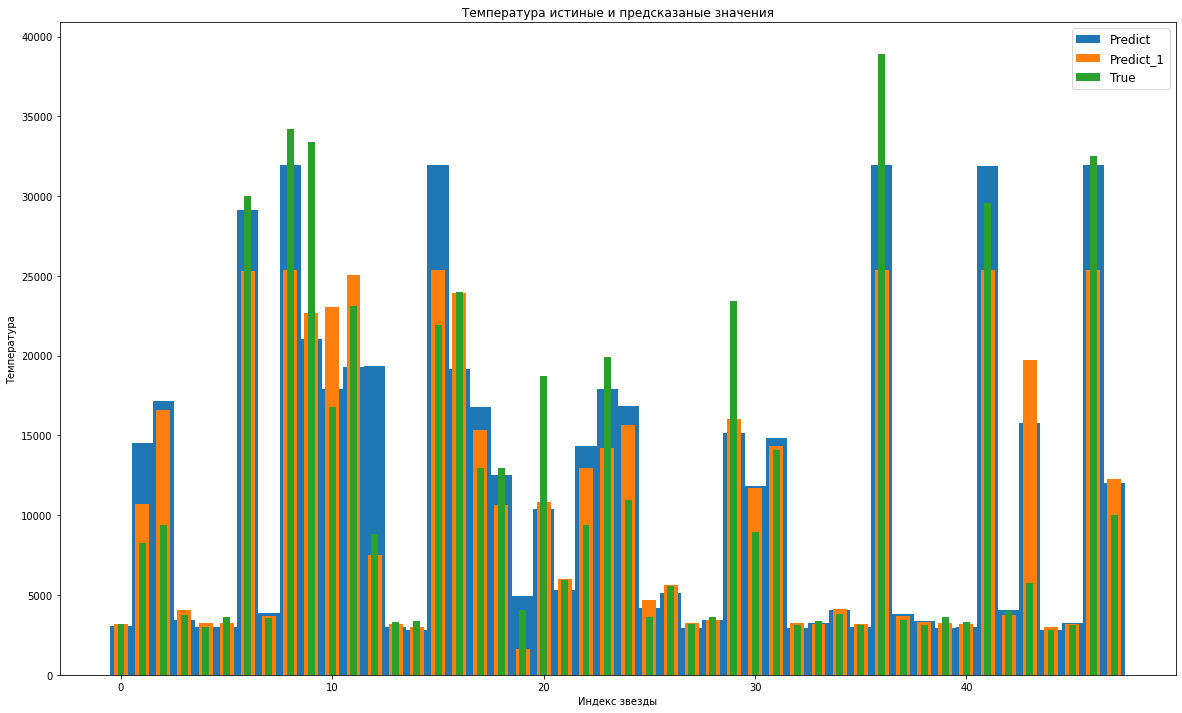

In [66]:
plt.figure(figsize=(20,12))
plt.bar(np.array(range(0,len(Y_test))),net.forward(X_test).flatten().detach(),width=1,label='Predict')
plt.bar(np.array(range(0,len(Y_test))),net_t.forward(X_test).flatten().detach(),width=.66,label='Predict_1')
plt.bar(np.array(range(0,len(Y_test))),Y_test,width=0.33,label='True')
plt.legend(loc='best', fontsize=12)
plt.title('Температура истиные и предсказаные значения')
plt.xlabel('Индекс звезды')
plt.ylabel('Температура')
plt.show()

Видно что в некоторых случаях модели угадывают практически идеальон, а вдруг отклонение существенно, но можно подметить, что обе сети ошибаются в одинаковых местах.

## Выводы

Проведя данное ислодование, обнаружили некоторые пробелы в данных, не критичные. После подготовки всего DF обучили много нейроных сетей для определения лучшей для данной задачи. В итоге получили две самые лучшие, с батчами и без. Они имеют очень схожие результаты, что видно из RMSE и финального графика.

In [67]:
bot_send('все')